In [ ]:
"""

create linear regression model for
target of US county 2019 median household income
and features gathered from multiple sources plus web scraping

Use Log transformed target 
see if interaction terms increase R2 and decrease RMSE

5 Kfold cross-validation

Hold out test set, same test set as held out with previous models


"""

In [11]:
import pickle
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score, mean_squared_error

import matplotlib.pyplot as plt

import scipy.stats as stats

In [12]:
with open('county_model_data.pickle', 'rb') as read_file:
    model_data = pickle.load(read_file)
    
model_data.head()

,FIPS_code,Stabr,area_name,Area_Name,Median_Household_Income_2019,Civilian_labor_force_2019,Unemployment_rate_2019,hwy_count,city_town_counts,Metro_2013,...,Farming_2015_Update,Mining_2015-Update,Manufacturing_2015_Update,Government_2015_Update,Recreation_2015_Update,Nonspecialized_2015_Update,Low_Education_2015_Update,Low_Employment_Cnty_2008_2012_25_64,Retirement_Dest_2015_Update,Persistent_Poverty_2013
0,01001,AL,"Autauga County, AL",Autauga County,58233.0,26172.0,2.7,6.0,4.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,01003,AL,"Baldwin County, AL",Baldwin County,59871.0,97328.0,2.7,12.0,14.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,01005,AL,"Barbour County, AL",Barbour County,35972.0,8537.0,3.8,11.0,6.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
3,01007,AL,"Bibb County, AL",Bibb County,47918.0,8685.0,3.1,8.0,5.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
4,01009,AL,"Blount County, AL",Blount County,52902.0,25331.0,2.7,9.0,16.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0


In [13]:
model_data.columns

Index(['FIPS_code', 'Stabr', 'area_name', 'Area_Name',
       'Median_Household_Income_2019', 'Civilian_labor_force_2019',
       'Unemployment_rate_2019', 'hwy_count', 'city_town_counts', 'Metro_2013',
       'Rural_urban_continuum_code_2013', 'Farming_2015_Update',
       'Mining_2015-Update', 'Manufacturing_2015_Update',
       'Government_2015_Update', 'Recreation_2015_Update',
       'Nonspecialized_2015_Update', 'Low_Education_2015_Update',
       'Low_Employment_Cnty_2008_2012_25_64', 'Retirement_Dest_2015_Update',
       'Persistent_Poverty_2013'],
      dtype='object')

In [14]:
# Preprocessing

# log tranform target
model_data['log_med_inc'] = np.log(model_data['Median_Household_Income_2019'])

# log transform civilian labor force
model_data['log_Civilian_LF'] = np.log(model_data['Civilian_labor_force_2019'])

In [15]:
# one hot encoding for Rural_urban_continuum_code_2013

ru_code = model_data[['Rural_urban_continuum_code_2013']]

one = OneHotEncoder(sparse=False)
one.fit(ru_code)
cats = one.transform(ru_code)

columns = one.get_feature_names(['Rural_urban_continuum_code_2013'])
ru_code_df = pd.DataFrame(cats, columns=columns, index=ru_code.index)

# drop the last column, so model intercept becomes about non-metro #9 classification

ru_code_df2 =  ru_code_df.iloc[ :, :-1]
ru_code_df2.head()

,Rural_urban_continuum_code_2013_1.0,Rural_urban_continuum_code_2013_2.0,Rural_urban_continuum_code_2013_3.0,Rural_urban_continuum_code_2013_4.0,Rural_urban_continuum_code_2013_5.0,Rural_urban_continuum_code_2013_6.0,Rural_urban_continuum_code_2013_7.0,Rural_urban_continuum_code_2013_8.0
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
proc_data = pd.concat([model_data, ru_code_df2], axis=1)

In [17]:
# split df 
X = proc_data[['log_Civilian_LF','Unemployment_rate_2019', 
       'hwy_count', 'city_town_counts', 'Metro_2013',
       'Farming_2015_Update', 'Mining_2015-Update', 'Manufacturing_2015_Update',
       'Government_2015_Update', 'Recreation_2015_Update',
       'Nonspecialized_2015_Update', 'Low_Education_2015_Update',
       'Low_Employment_Cnty_2008_2012_25_64', 'Retirement_Dest_2015_Update',
       'Persistent_Poverty_2013', 'Rural_urban_continuum_code_2013_1.0',
       'Rural_urban_continuum_code_2013_2.0',
       'Rural_urban_continuum_code_2013_3.0',
       'Rural_urban_continuum_code_2013_4.0',
       'Rural_urban_continuum_code_2013_5.0',
       'Rural_urban_continuum_code_2013_6.0',
       'Rural_urban_continuum_code_2013_7.0',
       'Rural_urban_continuum_code_2013_8.0']]

y = proc_data['log_med_inc']



In [18]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [19]:
from sklearn.preprocessing import PolynomialFeatures

# with log transform of target
# arrays for KFold
X, y = np.array(X_train_val), np.array(y_train_val)

kf = KFold(n_splits=5, shuffle=True, random_state = 47)
cv_lm_r2s = [] #collect the validation results R2
cv_lm_rmse = [] #collect the validation RMSE


for train_ind, val_ind in kf.split(X, y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #polynomial regression
    m = LinearRegression()
    p = PolynomialFeatures(degree=2, interaction_only=True)
    x_train_poly = p.fit_transform(X_train)
    m.fit(x_train_poly,y_train)
    
    cv_lm_r2s.append(round(m.score(p.transform(X_val), y_val), 3))
    
    y_pred = m.predict(p.transform(X_val))
    # log transformed target, need to put RMSE in original dollar terms 
    cv_lm_rmse.append(round(np.sqrt(mean_squared_error(np.exp(y_val), np.exp(y_pred))), 2))

print('Polynomial regression scores: ', cv_lm_r2s, '\n')

print(f'Mean CV r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}', '\n')

print(f'Polynomial regression RMSEs: ', cv_lm_rmse, '\n')

print(f'Mean CV RMSE:  {np.mean(cv_lm_rmse):.2f} +- {np.std(cv_lm_rmse):.2f}')

Polynomial regression scores:  [0.591, 0.606, 0.602, 0.599, 0.606] 

Mean CV r^2: 0.601 +- 0.006 

Polynomial regression RMSEs:  [9456.62, 9838.75, 9771.96, 8841.23, 8792.48] 

Mean CV RMSE:  9340.21 +- 446.65


In [20]:
coef_inter = list(zip(p.get_feature_names(list(X_train_val.columns)),m.coef_))
coef_inter_df = pd.DataFrame(coef_inter)
coef_inter_df.columns = ['feature', 'coef_inter']

# review all for any important interaction features
coef_inter_df.to_excel('coef_inter_df.xlsx', index=False)

Text(0, 0.5, 'residuals')

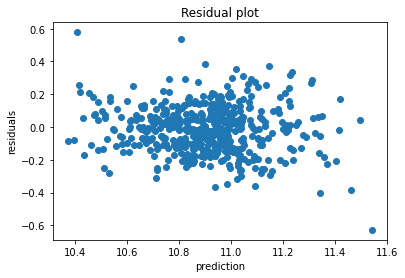

In [21]:
## last validation set residuals

y_pred = m.predict(p.transform(X_val))

res = y_val - y_pred
plt.scatter(y_pred, res)
plt.title("Residual plot")
plt.xlabel("prediction")
plt.ylabel("residuals")

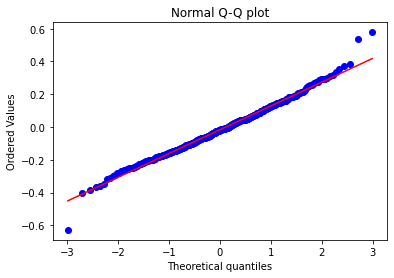

In [22]:
stats.probplot(res, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

In [23]:
##########
## see of any polynomial degree=2 terms helpful


from sklearn.preprocessing import PolynomialFeatures

# with log transform of target
# arrays for KFold
X, y = np.array(X_train_val), np.array(y_train_val)

kf = KFold(n_splits=5, shuffle=True, random_state = 47)
cv_lm_r2s = [] #collect the validation results R2
cv_lm_rmse = [] #collect the validation RMSE


for train_ind, val_ind in kf.split(X, y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #polynomial regression
    m = LinearRegression()
    p = PolynomialFeatures(degree=2) #, interaction_only=True)
    x_train_poly = p.fit_transform(X_train)
    m.fit(x_train_poly,y_train)
    
    cv_lm_r2s.append(round(m.score(p.transform(X_val), y_val), 3))
    
    y_pred = m.predict(p.transform(X_val))
    # log transformed target, need to put RMSE in original dollar terms 
    cv_lm_rmse.append(round(np.sqrt(mean_squared_error(np.exp(y_val), np.exp(y_pred))), 2))

print('Polynomial regression scores: ', cv_lm_r2s, '\n')

print(f'Mean CV r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}', '\n')

print(f'Polynomial regression RMSEs: ', cv_lm_rmse, '\n')

print(f'Mean CV RMSE:  {np.mean(cv_lm_rmse):.2f} +- {np.std(cv_lm_rmse):.2f}')

Polynomial regression scores:  [0.591, 0.613, 0.575, 0.584, 0.62] 

Mean CV r^2: 0.597 +- 0.017 

Polynomial regression RMSEs:  [9450.61, 9757.01, 10259.74, 9026.12, 8687.37] 

Mean CV RMSE:  9436.17 +- 549.59


In [24]:
coef_p2 = list(zip(p.get_feature_names(list(X_train_val.columns)),m.coef_))

In [26]:
coef_p2_df = pd.DataFrame(coef_p2)
coef_p2_df.columns = ['feature', 'coef_p2']

In [27]:
# review all for any important squared features
coef_p2_df.to_excel('coef_p2_df.xlsx', index=False)